### 0.1. Import Libraries

In [143]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import matplotlib as plt
from matplotlib import pyplot
from mlxtend.frequent_patterns import association_rules

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
from PIL import Image
from matplotlib.pyplot import figure
from sklearn.metrics.cluster import silhouette_score, calinski_harabasz_score, silhouette_samples
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 0.2. Data Pre-Processing

**Funtion to load the transactions as a matrix**

In [144]:
def load_transactions (file_name, sep='\t'):
    lines = open(file_name, 'rt').readlines()
    transactions_matrix = []
    for l in lines:
        l = l.rstrip('\n')
        transaction = l.split(sep)
        transactions_matrix.append(transaction)
    return transactions_matrix

**Load transaction matrix** <p>

Each transaction will refer to a particular molecule, specifying whether gene targets are active or not. <p>

The first index of each transaction has been removed as it concerns the name of the molecule, and we don't want to use it as an element in the transaction.


In [145]:
biotargets=load_transactions("acts.txt", sep="\t")

for i in biotargets:
    i.pop(0)

len(biotargets)

1101

The resultant matrix have 1001 molecules with the respective binary value for the targets.

**Compute the binary transactions as dataframe**

In [146]:
#Compute binary database
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(biotargets).transform(biotargets)
biotargets_df = pd.DataFrame(trans_array, columns=tr_enc.columns_)
biotargets_df.drop(biotargets_df.columns[0], axis=1, inplace=True)

**Label each row with molecule names**

In [147]:
molecular_labels = pd.read_csv("molecular_labels.csv", header=None)
mlabels_df = pd.DataFrame(molecular_labels)
mlabels_df.columns= ["Molecules"]

In [148]:
biotargets_df = biotargets_df.T
biotargets_df.columns = mlabels_df["Molecules"]
biotargets_df = biotargets_df.T

In [149]:
biotargets_df

,5HTR1D,AADAC,AAK1,ABAT,ABCB1,ABCB11,ABCB1A,ABCB1B,ABCC1,ABCC2,...,VDRA,VIM-2,VKORC1,VRK2,WEE1,WEE2,XBP1,XDH,YES1,ZAP70
Molecules,,,,,,,,,,,,,,,,,,,,,
PDFDA0001,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PDFDA0002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PDFDA0003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PDFDA0004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PDFDA0005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDFDA1097,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PDFDA1098,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PDFDA1099,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The resultante dataset have 1101 molecules (rows) with the information of the 1243 gene targets (columns). If they are active or not in that molecule.

### 1. Quick Exploratory Data Analysis

Inferring which gene targets are more active in the molecules

In [176]:
targets = {}
for i in biotargets_df.columns:
    targets[i] = [biotargets_df[i].values.sum()]

targets_sum = pd.DataFrame(targets).T
targets_sum.columns = ["Count"]

Top 10 gene targets with more counts for activeness

In [177]:
targets_sum.sort_values(by=["Count"], ascending=False).head(10)

,Count
REP,530
SLCO1B1,337
SLCO1B3,336
LMNA,244
CYP3A4,146
CYP2D6,140
SLC22A1,125
CHRM1,120
CYP2C19,107
CYP1A2,106


### 2. Association Rules Analysis

We will perform a association rules analysis in order to infer if a molecule binds to a set of gene targets it will bind to others.

Thus, we will perform this exploration using frequent itemsets with FPGrowth.

In [9]:
FI_fpgrowth = fpgrowth(biotargets_df, min_support=0.02, use_colnames=True)

In [10]:
FI_fpgrowth['length'] = FI_fpgrowth['itemsets'].apply(lambda x: len(x))
FI_fpgrowth_filt = FI_fpgrowth[FI_fpgrowth['length'] > 2]
FI_fpgrowth_filt.sort_values(['support'],ascending=False).groupby('length').head(10)

,support,itemsets,length
162,0.151680,"(SLCO1B1, SLCO1B3, REP)",3
109,0.099909,"(SLCO1B1, LMNA, SLCO1B3)",3
4256,0.076294,"(SLCO1B1, SLCO2B1, SLCO1B3)",3
167,0.064487,"(SLCO1B1, CYP3A4, SLCO1B3)",3
382,0.054496,"(HTR2A, HTR2C, HTR2B)",3
...,...,...,...
20307,0.021798,"(ADRA1B, HTR2A, HTR1A, HTR2B, ADRA1A, ADRA1D, ...",12
16219,0.021798,"(HTR2A, DRD2, HTR2B, ADRA1A, ADRA1D, HTR2C, HT...",12
19667,0.021798,"(ADRA1B, HTR2A, DRD2, HTR2B, ADRA1A, ADRA1D, H...",12
19793,0.021798,"(ADRA1B, HTR2A, DRD2, HTR2B, ADRA1A, ADRA1D, H...",12


**Identifying the Best Rules** <p>

In this step we will explore which rules can give us more information, based on support, confidence and lift metrics.

In [11]:
rules = association_rules(FI_fpgrowth, metric="confidence", min_threshold=0.8)

**By Support**

In [80]:
print("Top 10 rules with greater support:")
rules.sort_values(by=['support'], ascending=False).head(10)

Top 10 rules with greater support:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length
35,(SLCO1B1),(SLCO1B3),0.306085,0.305177,0.297911,0.973294,3.189275,0.204501,26.017257,1,1
36,(SLCO1B3),(SLCO1B1),0.305177,0.306085,0.297911,0.976190,3.189275,0.204501,29.144414,1,1
38,"(SLCO1B3, REP)",(SLCO1B1),0.153497,0.306085,0.151680,0.988166,3.228399,0.104697,58.635786,2,1
37,"(SLCO1B1, REP)",(SLCO1B3),0.156222,0.305177,0.151680,0.970930,3.181530,0.104005,23.901907,2,1
7,"(SLCO1B1, LMNA)",(SLCO1B3),0.102634,0.305177,0.099909,0.973451,3.189791,0.068588,26.171662,2,1
8,"(SLCO1B3, LMNA)",(SLCO1B1),0.102634,0.306085,0.099909,0.973451,3.180326,0.068494,26.137451,2,1
101581,(SLCO2B1),(SLCO1B3),0.087193,0.305177,0.080836,0.927083,3.037853,0.054226,9.529000,1,1
101582,(SLCO2B1),(SLCO1B1),0.087193,0.306085,0.080836,0.927083,3.028839,0.054147,9.516543,1,1
101585,(SLCO2B1),"(SLCO1B1, SLCO1B3)",0.087193,0.297911,0.076294,0.875000,2.937119,0.050318,5.616712,1,2
101584,"(SLCO2B1, SLCO1B3)",(SLCO1B1),0.080836,0.306085,0.076294,0.943820,3.083519,0.051552,12.351680,2,1


**By Confidence**

In [13]:
print("Top 10 rules with greater confidence:")
rules.sort_values(by=['confidence'], ascending=False).head(10)

Top 10 rules with greater confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2539877,"(HTR2A, HTR2B, CHRM4, HTR6, SLC6A4, ADRA2A)","(CHRM2, CHRM3)",0.020890,0.043597,0.020890,1.0,22.937500,0.019979,inf
2558743,"(HTR2A, DRD1, ADRA2B, CHRM3)",(CHRM1),0.022707,0.108992,0.022707,1.0,9.175000,0.020232,inf
2558777,"(DRD1, CHRM3, CHRM1)","(HTR2B, DRD3)",0.022707,0.049046,0.022707,1.0,20.388889,0.021593,inf
2558776,"(DRD1, CHRM3, DRD3)","(HTR2B, CHRM1)",0.022707,0.040872,0.022707,1.0,24.466667,0.021779,inf
2558774,"(DRD1, HTR2B, CHRM3)","(CHRM1, DRD3)",0.022707,0.039055,0.022707,1.0,25.604651,0.021820,inf
2558772,"(DRD1, CHRM1, CHRM3, DRD3)",(HTR2B),0.022707,0.076294,0.022707,1.0,13.107143,0.020974,inf
2558770,"(DRD1, HTR2B, CHRM3, CHRM1)",(DRD3),0.022707,0.073569,0.022707,1.0,13.592593,0.021036,inf
2558768,"(DRD1, HTR2B, CHRM3, DRD3)",(CHRM1),0.022707,0.108992,0.022707,1.0,9.175000,0.020232,inf
2558767,"(DRD1, CHRM3)","(CHRM1, ADRA2A, DRD3)",0.022707,0.031789,0.022707,1.0,31.457143,0.021985,inf
2558764,"(DRD1, ADRA2A, CHRM3)","(CHRM1, DRD3)",0.022707,0.039055,0.022707,1.0,25.604651,0.021820,inf


**By Lift**

In [14]:
print("Top 10 rules with greater lift:")
rules.sort_values(by=['lift'], ascending=False).head(10)

Top 10 rules with greater lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2346416,"(HTR2B, ADRA1D, CHRM4, CHRM2, SLC6A2, CHRM1)","(HTR2A, CHRM3, HTR6, DRD3, ADRA2A)",0.020890,0.022707,0.02089,1.00,44.04,0.020416,inf
2775011,"(DRD1, ADRA2B, CHRM2, SLC6A2)","(CHRM3, CHRM4, HTR6, DRD3, ADRA2A)",0.020890,0.022707,0.02089,1.00,44.04,0.020416,inf
2775298,"(DRD1, CHRM2, SLC6A2, CHRM1, ADRA2B)","(HTR6, ADRA2A, CHRM3, DRD3)",0.020890,0.022707,0.02089,1.00,44.04,0.020416,inf
2775309,"(HTR6, ADRA2A, CHRM3, DRD3)","(DRD1, CHRM2, SLC6A2, CHRM1, ADRA2B)",0.022707,0.020890,0.02089,0.92,44.04,0.020416,12.238874
2821439,"(HTR2A, CHRM3, CHRM4, HTR6, DRD3, CHRM1, ADRA2A)","(HTR2B, DRD1, CHRM2, SLC6A2, ADRA2B)",0.022707,0.020890,0.02089,0.92,44.04,0.020416,12.238874
2347974,"(HTR2B, CHRM3, DRD3, CHRM2, ADRA2B, ADRA2A)","(HTR2A, ADRA1D, CHRM4, HTR6, SLC6A2)",0.022707,0.020890,0.02089,0.92,44.04,0.020416,12.238874
2349991,"(CHRM3, CHRM4, HTR6, DRD3, ADRA2A)","(HTR2B, ADRA1D, CHRM2, SLC6A2, CHRM1, ADRA2B)",0.022707,0.020890,0.02089,0.92,44.04,0.020416,12.238874
2351337,"(HTR2A, HTR2B, ADRA1D, CHRM4, CHRM2, SLC6A2, A...","(CHRM3, HTR6, DRD3, CHRM1, ADRA2A)",0.020890,0.022707,0.02089,1.00,44.04,0.020416,inf
2342616,"(HTR2A, HTR2B, CHRM3, DRD3, CHRM2, ADRA2B, ADR...","(SLC6A2, ADRA1D, HTR6, CHRM1)",0.022707,0.020890,0.02089,0.92,44.04,0.020416,12.238874
2798380,"(HTR2A, CHRM3, CHRM4, HTR6, DRD3, ADRA2A)","(DRD1, ADRA2B, CHRM2, SLC6A2)",0.022707,0.020890,0.02089,0.92,44.04,0.020416,12.238874


**By Support, confidence, lift group by the lenght of antecendents**

In [15]:
rules['ante_length'] = rules['antecedents'].apply(lambda x: len(x))
rules['cons_length'] = rules['consequents'].apply(lambda x: len(x))

In [16]:
rules.sort_values(['support','confidence','lift'],ascending=False).groupby('ante_length').head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length
36,(SLCO1B3),(SLCO1B1),0.305177,0.306085,0.297911,0.976190,3.189275,0.204501,29.144414,1,1
35,(SLCO1B1),(SLCO1B3),0.306085,0.305177,0.297911,0.973294,3.189275,0.204501,26.017257,1,1
38,"(SLCO1B3, REP)",(SLCO1B1),0.153497,0.306085,0.151680,0.988166,3.228399,0.104697,58.635786,2,1
37,"(SLCO1B1, REP)",(SLCO1B3),0.156222,0.305177,0.151680,0.970930,3.181530,0.104005,23.901907,2,1
7,"(SLCO1B1, LMNA)",(SLCO1B3),0.102634,0.305177,0.099909,0.973451,3.189791,0.068588,26.171662,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1156463,"(HTR2A, ADRA1B, DRD2, ADRA1D, ADRA1A, HTR2C, H...",(HTR2B),0.021798,0.076294,0.021798,1.000000,13.107143,0.020135,inf,12,1
1156454,"(HTR2A, ADRA1B, DRD2, HTR2B, ADRA1A, ADRA1D, H...",(ADRA2A),0.021798,0.077203,0.021798,1.000000,12.952941,0.020115,inf,12,1
1156465,"(ADRA1B, DRD2, HTR2B, ADRA1D, ADRA1A, HTR2C, H...",(HTR2A),0.021798,0.080836,0.021798,1.000000,12.370787,0.020036,inf,12,1
1156457,"(HTR2A, ADRA1B, DRD2, HTR2B, ADRA1A, ADRA1D, H...",(DRD1),0.022707,0.055404,0.021798,0.960000,17.327213,0.020540,23.614896,12,1


**By Support, confidence, lift group by the lenght of consequents**

In [81]:
rules.sort_values(['support','confidence','lift'],ascending=False).groupby('cons_length').head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length
36,(SLCO1B3),(SLCO1B1),0.305177,0.306085,0.297911,0.976190,3.189275,0.204501,29.144414,1,1
35,(SLCO1B1),(SLCO1B3),0.306085,0.305177,0.297911,0.973294,3.189275,0.204501,26.017257,1,1
38,"(SLCO1B3, REP)",(SLCO1B1),0.153497,0.306085,0.151680,0.988166,3.228399,0.104697,58.635786,2,1
37,"(SLCO1B1, REP)",(SLCO1B3),0.156222,0.305177,0.151680,0.970930,3.181530,0.104005,23.901907,2,1
7,"(SLCO1B1, LMNA)",(SLCO1B3),0.102634,0.305177,0.099909,0.973451,3.189791,0.068588,26.171662,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1964675,"(DRD1, CHRM2)","(HTR2A, HTR2B, ADRA1D, HTR2C, CHRM4, HTR6, DRD...",0.024523,0.021798,0.020890,0.851852,39.078704,0.020356,6.602861,2,10
2823808,"(DRD1, CHRM2)","(HTR2A, HTR2B, CHRM3, CHRM4, HTR6, DRD3, SLC6A...",0.024523,0.021798,0.020890,0.851852,39.078704,0.020356,6.602861,2,10
2890423,"(DRD1, CHRM2)","(HTR2A, HTR2B, CHRM3, HTR2C, CHRM4, HTR6, DRD3...",0.024523,0.021798,0.020890,0.851852,39.078704,0.020356,6.602861,2,10
2964058,"(DRD1, CHRM2)","(HTR2A, HTR2B, CHRM3, ADRA1D, CHRM4, HTR6, DRD...",0.024523,0.021798,0.020890,0.851852,39.078704,0.020356,6.602861,2,10


The top association rules ordered by confidence show to be 1 with infinite value for conviction metric, what seems not to be the best metric to choose the rules. <p>

Rules with greater lift values have shown very low support values. <p>


Taking into account the trade-off between metrics and a reasonable support value, we select as more informative and supported association rules:

 * (SLCO1B3) -->(SLCO1B1)	
 * (SLCO1B1) -->(SLCO1B3)	

 * (SLCO1B3, REP) --> (SLCO1B1) 
 * (SLCO1B1, REP) --> (SLCO1B3) 

 * (LMNA, SLCO1B1) --> (SLCO1B3) 
 * (LMNA, SLCO1B3) --> (SLCO1B1)

In the next steps will perform a exploration analysis focused on the selected gene targets (binding sites), in order to understand if exist a relation between them.

**Which molecules have all the selected gene targets active?**

In [17]:
find_targets = biotargets_df[biotargets_df['SLCO1B1'] & biotargets_df['SLCO1B3'] & biotargets_df['LMNA'] & biotargets_df['REP'] == True]

mol_sel_target = find_targets[['SLCO1B1','SLCO1B3','LMNA','REP']]

print("\nThe targets are active in ", len(mol_sel_target.index), " molecules")
mol_sel_target


The targets are active in  50  molecules


,SLCO1B1,SLCO1B3,LMNA,REP
Molecules,,,,
PDFDA0016,True,True,True,True
PDFDA0022,True,True,True,True
PDFDA0039,True,True,True,True
PDFDA0060,True,True,True,True
PDFDA0083,True,True,True,True
PDFDA0085,True,True,True,True
PDFDA0092,True,True,True,True
PDFDA0095,True,True,True,True
PDFDA0099,True,True,True,True


**Which molecules have SLCO1B1 gene target active?**

In [18]:
find_targets_S1 = biotargets_df.query('SLCO1B1 == True')

mol_sel_target_S1 = find_targets_S1[['SLCO1B1']]

print("\nThe target SLCO1B1 is active in ", len(mol_sel_target_S1.index), " molecules")
mol_sel_target_S1


The target SLCO1B1 is active in  337  molecules


,SLCO1B1
Molecules,
PDFDA0005,True
PDFDA0008,True
PDFDA0010,True
PDFDA0016,True
PDFDA0017,True
...,...
PDFDA1079,True
PDFDA1081,True
PDFDA1085,True


**Which molecules have SLCO1B3 gene target active?**

In [19]:
find_targets_S3 = biotargets_df.query('SLCO1B3 == True')

mol_sel_target_S3 = find_targets_S3[['SLCO1B3']]

print("\nThe target SLCO1B3 is active in ", len(mol_sel_target_S3.index), " molecules")
mol_sel_target_S3


The target SLCO1B3 is active in  336  molecules


,SLCO1B3
Molecules,
PDFDA0005,True
PDFDA0008,True
PDFDA0010,True
PDFDA0016,True
PDFDA0017,True
...,...
PDFDA1079,True
PDFDA1081,True
PDFDA1085,True


**Which molecules have SLCO1B1 and SLCO1B3 gene targets active?**

In [91]:
find_targets_S = biotargets_df.query('SLCO1B1 == True and SLCO1B3 == True')

mol_sel_target_S = find_targets_S[['SLCO1B1','SLCO1B3']]

print("SLCO1B1 and SLCO1B3 are both active in ", len(mol_sel_target_S.index), " molecules")
mol_sel_target_S

SLCO1B1 and SLCO1B3 are both active in  328  molecules


,SLCO1B1,SLCO1B3
Molecules,,
PDFDA0005,1,1
PDFDA0008,1,1
PDFDA0010,1,1
PDFDA0016,1,1
PDFDA0017,1,1
...,...,...
PDFDA1079,1,1
PDFDA1081,1,1
PDFDA1085,1,1


**Which molecules have SLCO1B1 gene target active and SLCO1B3 not active?**

In [87]:
find_targets_S = biotargets_df.query('SLCO1B1 == True and SLCO1B3 == False')

mol_sel_target_S = find_targets_S[['SLCO1B1','SLCO1B3']]

print(len(mol_sel_target_S .index), "molecules have SLCO1B1 gene target active and SLCO1B3 not active")
mol_sel_target_S

9 molecules have SLCO1B1 gene target active and SLCO1B3 not active


,SLCO1B1,SLCO1B3
Molecules,,
PDFDA0144,1,0
PDFDA0328,1,0
PDFDA0490,1,0
PDFDA0498,1,0
PDFDA0674,1,0
PDFDA0741,1,0
PDFDA0791,1,0
PDFDA0867,1,0
PDFDA0969,1,0


**Which molecules have SLCO1B1 target not active and SLCO1B3 active ?**

In [86]:
find_targets_S = biotargets_df.query('SLCO1B1 == False and SLCO1B3 == True')

mol_sel_target_S = find_targets_S[['SLCO1B1','SLCO1B3']]

print("SLCO1B1 gene target are not active and SLCO1B3 active in", len(mol_sel_target_S .index), "molecules")
mol_sel_target_S

SLCO1B1 gene target are not active and SLCO1B3 active in 8 molecules


,SLCO1B1,SLCO1B3
Molecules,,
PDFDA0086,0,1
PDFDA0182,0,1
PDFDA0351,0,1
PDFDA0365,0,1
PDFDA0404,0,1
PDFDA0557,0,1
PDFDA0625,0,1
PDFDA0794,0,1


**Which molecules have REP gene target active?**

In [85]:
find_targets_R = biotargets_df[biotargets_df['REP']  == True]

mol_sel_target_R = find_targets_R[['REP']]

print("\nThe gene target REP is active in ", len(mol_sel_target_R.index), " molecules")
mol_sel_target_R


The gene target REP is active in  530  molecules


,REP
Molecules,
PDFDA0003,1
PDFDA0007,1
PDFDA0008,1
PDFDA0010,1
PDFDA0012,1
...,...
PDFDA1095,1
PDFDA1096,1
PDFDA1097,1


**Which molecules have LMNA gene target active?**

In [23]:
find_targets_L = biotargets_df[biotargets_df['LMNA']  == True]

mol_sel_target_L = find_targets_L[['LMNA']]

print("\nThe target LMNA is active in ", len(mol_sel_target_L.index), " molecules")
mol_sel_target_L


The target LMNA is active in  244  molecules


,LMNA
Molecules,
PDFDA0004,True
PDFDA0014,True
PDFDA0016,True
PDFDA0019,True
PDFDA0022,True
...,...
PDFDA1094,True
PDFDA1096,True
PDFDA1098,True


### 2. Clustering

We will perform a cluster analysis in order to infer the existence of patterns and associations/relations between the selected targets.

In [24]:
biotargets_df.replace({False: 0, True: 1}, inplace=True)

In [25]:
biotargets_df.head(5)

,5HTR1D,AADAC,AAK1,ABAT,ABCB1,ABCB11,ABCB1A,ABCB1B,ABCC1,ABCC2,...,VDRA,VIM-2,VKORC1,VRK2,WEE1,WEE2,XBP1,XDH,YES1,ZAP70
Molecules,,,,,,,,,,,,,,,,,,,,,
PDFDA0001,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PDFDA0002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PDFDA0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PDFDA0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PDFDA0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Heatmap**

<AxesSubplot:>

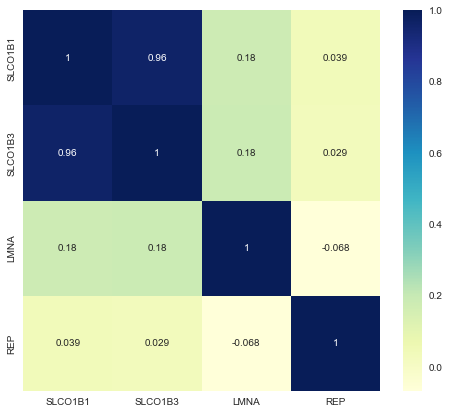

In [74]:
corr = biotargets_df[['SLCO1B1','SLCO1B3','LMNA','REP']].corr(method='pearson')
# fig = px.imshow(corr, text_auto=True, width=500, height=500)

# fig.update_layout(
#     yaxis=dict(tickfont=dict(size=10)),
#     xaxis=dict(tickfont=dict(size=10)))

# fig.show()

figure(figsize=(8, 7))
sns.heatmap(corr, annot=True, cmap="YlGnBu")

A ocorrência da ligação do fármaco com os binding sites SLCO1B1 SLCO1B3 parece estar correlacionada. Ao ocorrer a ligação num site tambem ocorrerá no outro. <p> Os sites REP e LMNA aparentam ser intermediários para estabilizar as ligações com os sites do tipo SLCO1. Um fármaco para se ligar aos sites do tipo SLCO1 liga-se antes ou ao REP ou ao LMNA.

**PCA**

In [27]:
def elbow_knee(data, model, K):
    # Instantiate the clustering model and visualizer
    visualizer = KElbowVisualizer(model, metric='silhouette', k=(2, K))

    visualizer.fit(data)        # Fit the data to the visualizer
    visualizer.show()

In [124]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    figure(figsize=(6,4))
    ax1 = pyplot.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    pyplot.show()

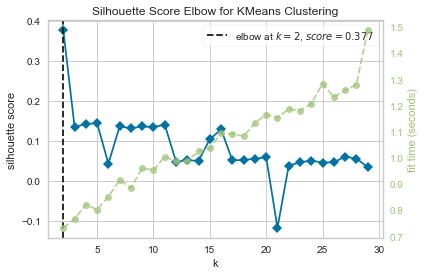

In [77]:
figure(figsize=(6, 4))
elbow_knee(biotargets_df, KMeans(), 30)

In [105]:
kmeans = KMeans(n_clusters=2, random_state=42)

cluster_targets = biotargets_df.copy(deep=True)
cluster_targets['cluster'] = kmeans.fit_predict(biotargets_df)

print("Silhouette Score:", silhouette_score(biotargets_df, kmeans.labels_),"\n",
      "The lowest SSE value:",kmeans.inertia_,"\n", 
      "Calinski Harabasz Score:",calinski_harabasz_score(biotargets_df, kmeans.labels_),"\n\n",
      "Final locations of the centroid:","\n",kmeans.cluster_centers_,"\n\n",
      "The number of iterations required to converge:",kmeans.n_iter_)

Silhouette Score: 0.3768553720906 
 The lowest SSE value: 8386.668302257118 
 Calinski Harabasz Score: 106.13420114670004 

 Final locations of the centroid: 
 [[2.16840434e-19 2.16840434e-19 8.67361738e-19 ... 8.67361738e-19
  1.73472348e-18 2.16840434e-19]
 [9.81354269e-04 9.81354269e-04 4.90677134e-03 ... 2.94406281e-03
  7.85083415e-03 9.81354269e-04]] 

 The number of iterations required to converge: 16


In [101]:
nclusts=len(set(kmeans.labels_))
cluster_elements_count = np.bincount(kmeans.labels_)
for i in range(nclusts):
    print("Cluster: ", i +1, "-->", cluster_elements_count[i], "data points") 

Cluster:  1 --> 82 data points
Cluster:  2 --> 1019 data points


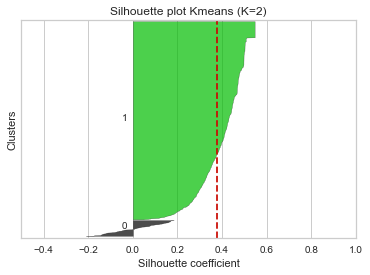

In [125]:
drawSillouette(biotargets_df, kmeans.labels_, "Kmeans (K=2)")

In [30]:
pca = pd.DataFrame(PCA(n_components=2).fit_transform(biotargets_df), columns= ["PC1","PC2"])

In [31]:
pca

,PC1,PC2
0,-0.310511,0.213444
1,-0.270234,0.201781
2,-0.474279,0.162219
3,0.018158,-0.022190
4,0.177521,-0.840853
...,...,...
1096,0.187946,-0.393316
1097,-0.422368,-0.594997
1098,-0.495152,0.144272
1099,-0.370223,0.203410


In [32]:
pca_targets = pd.concat([pca.reset_index(drop=True), cluster_targets.reset_index(drop=True)], axis=1)
pca_targets = pd.concat([mlabels_df.reset_index(drop=True), pca_targets.reset_index(drop=True)], axis=1)
pca_targets

,Molecules,PC1,PC2,5HTR1D,AADAC,AAK1,ABAT,ABCB1,ABCB11,ABCB1A,...,VIM-2,VKORC1,VRK2,WEE1,WEE2,XBP1,XDH,YES1,ZAP70,cluster
0,PDFDA0001,-0.310511,0.213444,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,PDFDA0002,-0.270234,0.201781,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,PDFDA0003,-0.474279,0.162219,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,PDFDA0004,0.018158,-0.022190,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,PDFDA0005,0.177521,-0.840853,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,PDFDA1097,0.187946,-0.393316,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1097,PDFDA1098,-0.422368,-0.594997,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1098,PDFDA1099,-0.495152,0.144272,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1099,PDFDA1100,-0.370223,0.203410,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
pca_targets['SLCO1B1'] = pca_targets['SLCO1B1'].astype(str)
pca_targets['SLCO1B3'] = pca_targets['SLCO1B3'].astype(str)
pca_targets['LMNA'] = pca_targets['LMNA'].astype(str)
pca_targets['REP'] = pca_targets['REP'].astype(str)
pca_targets['cluster'] = pca_targets['cluster'].astype(str)

### 3. Cluster Exploratory Analysis

**Note:** Due to Jupyter Notebook not having sufficient cache memory to save the results of the iteractive plots (plotly), we saved the iteractive plot versions on the directory `interative_plots_exported`, and used a saved static version.

**Cluster 1 Vs. Cluster 2**

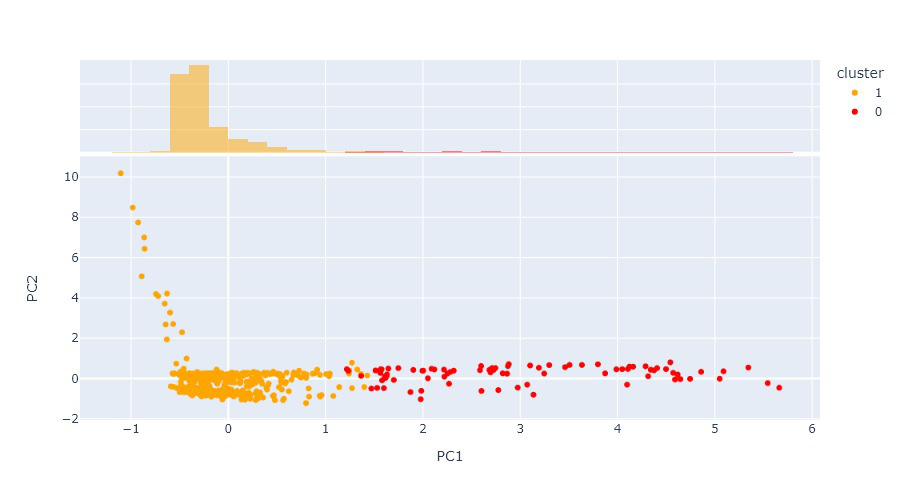

In [54]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'cluster',
                    hover_name='Molecules',
                    marginal_x="histogram",
                    color_discrete_sequence=["orange","red"],
                    width=900, height=500)
# fig.show()
                     
fig.write_html("interative_plots_exported/cluster1_vs_cluster2.html")     
fig.write_image("exported_plots/cluster1_vs_cluster2.jpg")   

cluster1_cluster2 = Image.open('exported_plots/cluster1_vs_cluster2.jpg')
cluster1_cluster2

**2 Clusters Vs. SLCO1B1**

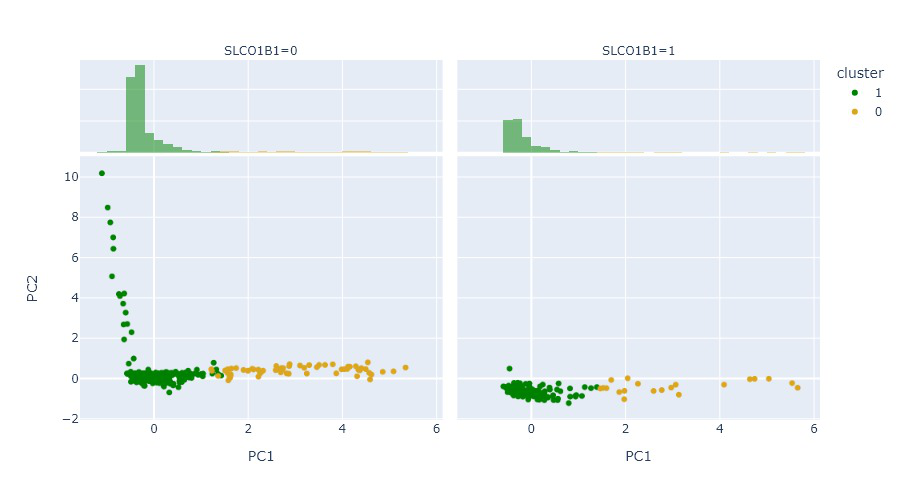

In [56]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'cluster', facet_col='SLCO1B1',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["green", "goldenrod"],
                    width=900, height=500)
# fig.show()
                    
fig.write_html("interative_plots_exported/SLCO1B1_clusters.html")     
fig.write_image("exported_plots/SLCO1B1_clusters.jpg")   

SLCO1B1_clusters = Image.open('exported_plots/SLCO1B1_clusters.jpg')
SLCO1B1_clusters

**2 Cluster Vs. SLCO1B3**

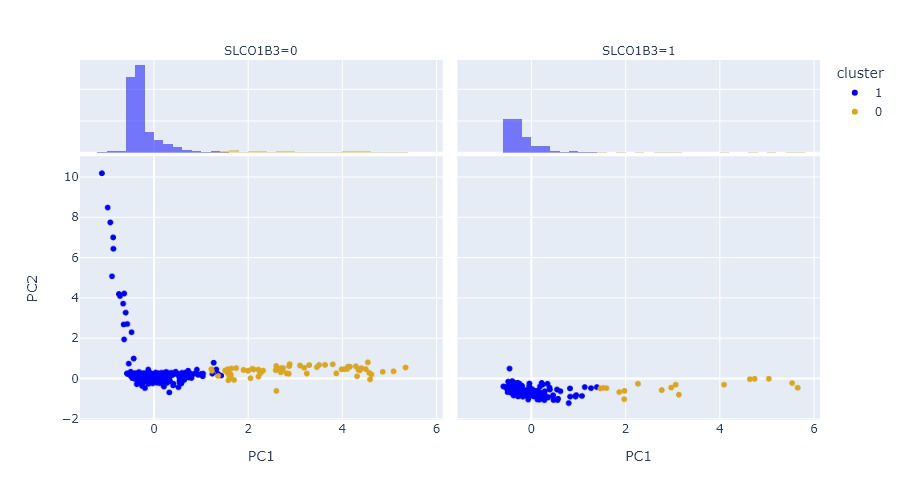

In [57]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'cluster', facet_col='SLCO1B3',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["blue", "goldenrod"],
                    width=900, height=500)
# fig.show()
                    
fig.write_html("interative_plots_exported/SLCO1B3_clusters.html")     
fig.write_image("exported_plots/SLCO1B3_clusters.jpg")   

SLCO1B3_clusters = Image.open('exported_plots/SLCO1B3_clusters.jpg')
SLCO1B3_clusters

**2 Clusters Vs. REP**

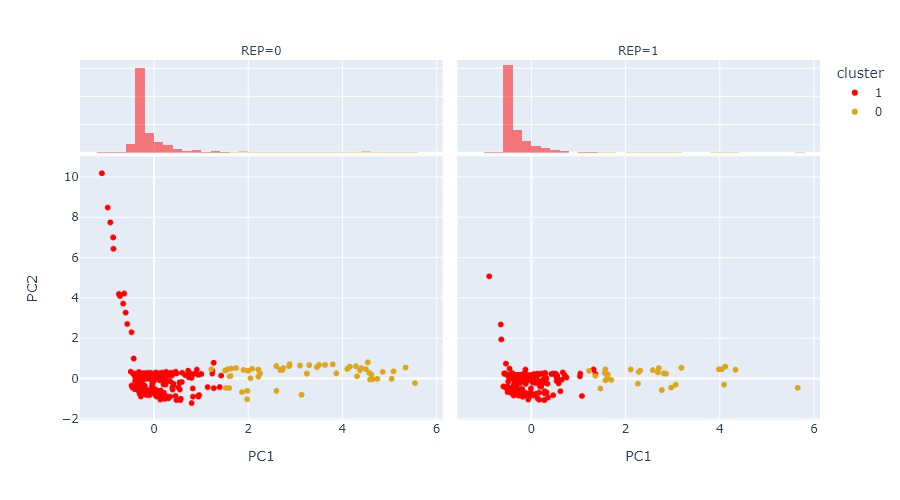

In [58]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'cluster', facet_col='REP',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["red", "goldenrod"],
                    width=900, height=500)
# fig.show()

fig.write_html("interative_plots_exported/REP_clusters.html")     
fig.write_image("exported_plots/REP_clusters.jpg")   

REP_clusters = Image.open('exported_plots/REP_clusters.jpg')
REP_clusters

**2 Clusters Vs. LMNA**

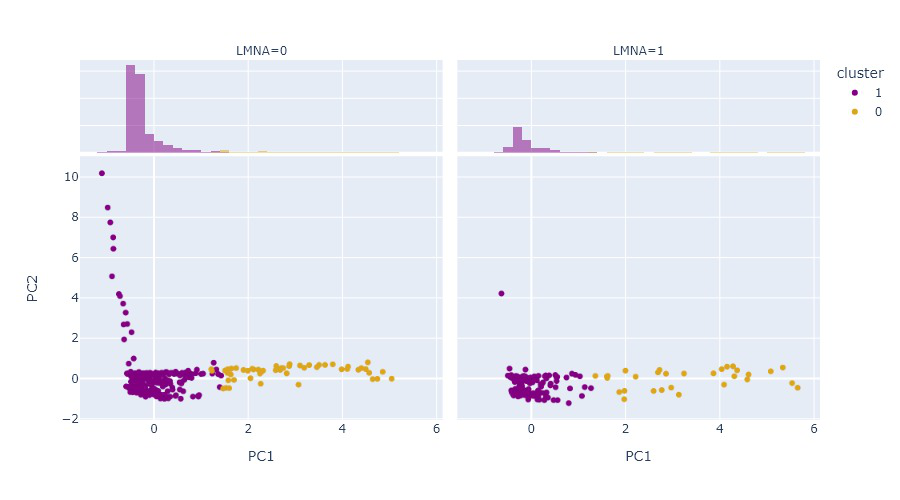

In [59]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'cluster', facet_col='LMNA',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["purple", "goldenrod"],
                    width=900, height=500)
# fig.show()

fig.write_html("interative_plots_exported/LMNA_clusters.html")     
fig.write_image("exported_plots/LMNA_clusters.jpg")   

LMNA_clusters = Image.open('exported_plots/LMNA_clusters.jpg')
LMNA_clusters

**SLCO1B1 Vs. SLCO1B3**

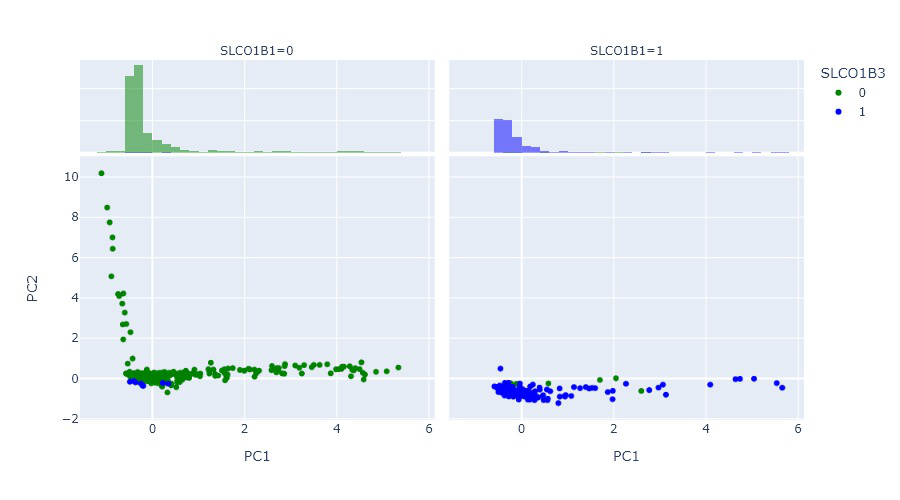

In [60]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'SLCO1B3', facet_col='SLCO1B1',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["green","blue"],
                    width=900, height=500)
# fig.show()

fig.write_html("interative_plots_exported/SLCO1B1_SLCO1B3.html")     
fig.write_image("exported_plots/SLCO1B1_SLCO1B3.jpg")   

SLCO1B1_SLCO1B3 = Image.open('exported_plots/SLCO1B1_SLCO1B3.jpg')
SLCO1B1_SLCO1B3

**REP Vs. LMNA**

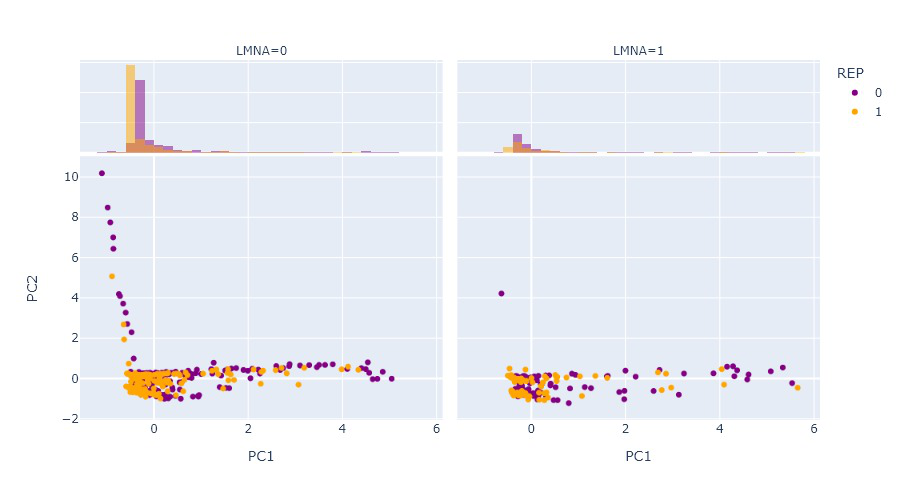

In [61]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'REP', facet_col='LMNA',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["purple","orange"],
                    width=900, height=500)
#fig.show()

fig.write_html("interative_plots_exported/REP_LMNA.html")     
fig.write_image("exported_plots/REP_LMNA.jpg")   

REP_LMNA = Image.open('exported_plots/REP_LMNA.jpg')
REP_LMNA

**SLCO1B1 Vs. REP**

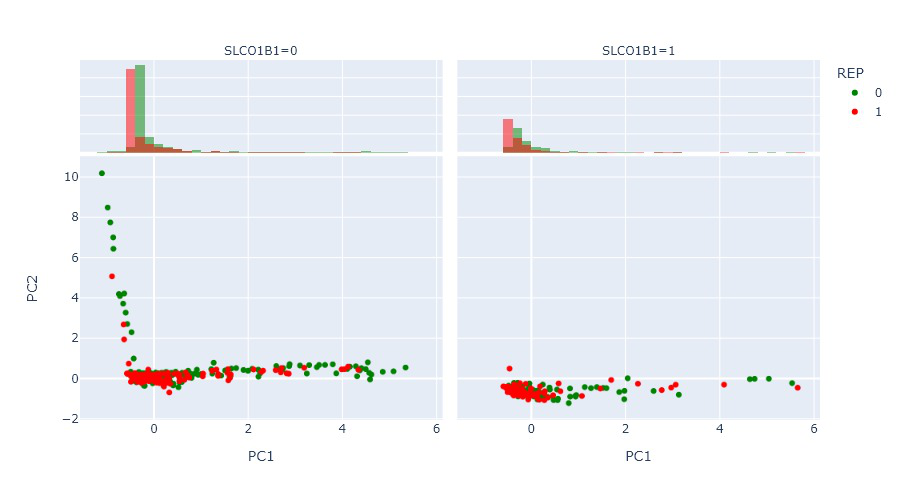

In [62]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'REP', facet_col='SLCO1B1',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["green","red"],
                    width=900, height=500)
#fig.show()

fig.write_html("interative_plots_exported/SLCO1B1_REP.html")     
fig.write_image("exported_plots/SLCO1B1_REP.jpg")   

SLCO1B1_REP = Image.open('exported_plots/SLCO1B1_REP.jpg')
SLCO1B1_REP

**SLCO1B3 Vs. REP**

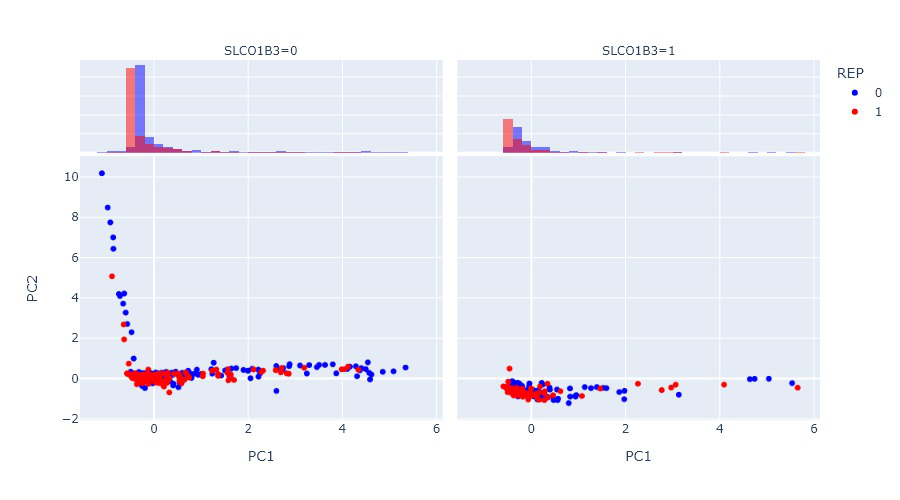

In [63]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'REP', facet_col='SLCO1B3',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["blue","red"],
                    width=900, height=500)
#fig.show()

fig.write_html("interative_plots_exported/SLCO1B3_REP.html")     
fig.write_image("exported_plots/SLCO1B3_REP.jpg")   

SLCO1B3_REP = Image.open('exported_plots/SLCO1B3_REP.jpg')
SLCO1B3_REP

**SLCO1B1 VS. LMNA**

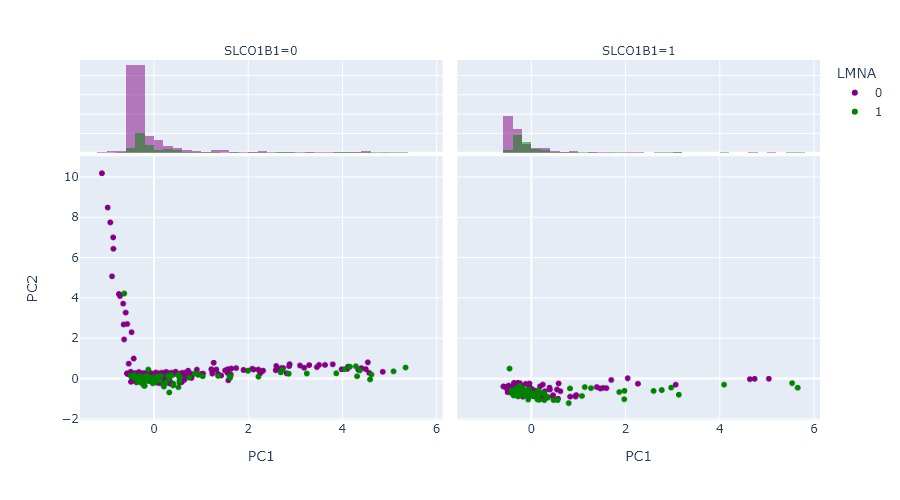

In [64]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'LMNA', facet_col='SLCO1B1',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["purple","green"],
                    width=900, height=500)
#fig.show()

fig.write_html("interative_plots_exported/SLCO1B1_LMNA.html")     
fig.write_image("exported_plots/SLCO1B1_LMNA.jpg")   

SLCO1B1_LMNA = Image.open('exported_plots/SLCO1B1_LMNA.jpg')
SLCO1B1_LMNA

**SLCO1B3 VS. LMNA**

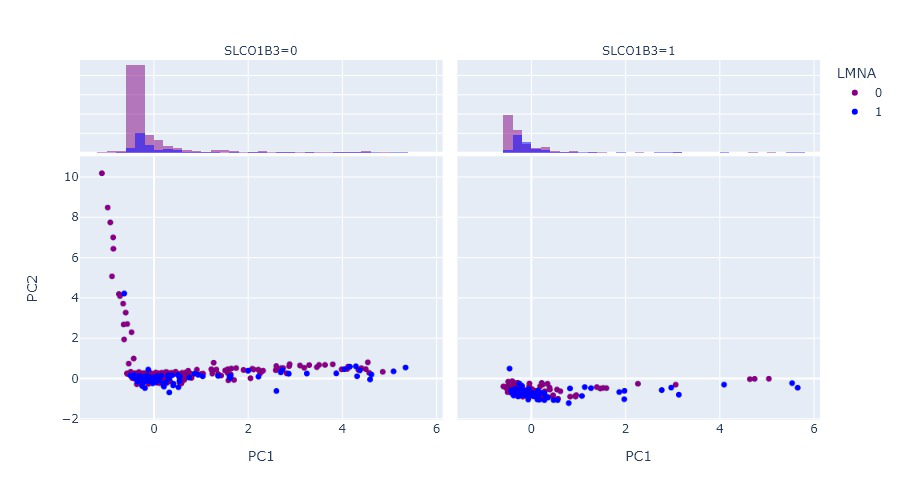

In [65]:
fig = px.scatter(pca_targets, x='PC1', y='PC2', 
                    color= 'LMNA', facet_col='SLCO1B3',
                    hover_name='Molecules',
                    marginal_x="histogram", marginal_y="box",
                    color_discrete_sequence=["purple","blue"],
                    width=900, height=500)
#fig.show()

fig.write_html("interative_plots_exported/SLCO1B3_LMNA.html")     
fig.write_image("exported_plots/SLCO1B3_LMNA.jpg")   

SLCO1B3_LMNA = Image.open('exported_plots/SLCO1B3_LMNA.jpg')
SLCO1B3_LMNA

**What are the most dispersed points from the clusters in PC2?**

In [48]:
out_points = pca_targets[pca_targets["PC2"] > 1.8]
out_points[['Molecules','SLCO1B1','SLCO1B3','LMNA','REP']]

,Molecules,SLCO1B1,SLCO1B3,LMNA,REP
19,PDFDA0020,0,0,0,0
130,PDFDA0131,0,0,0,0
253,PDFDA0254,0,0,0,1
262,PDFDA0263,0,0,0,0
367,PDFDA0368,0,0,0,0
452,PDFDA0453,0,0,1,0
496,PDFDA0497,0,0,0,0
715,PDFDA0716,0,0,0,0
771,PDFDA0772,0,0,0,0
821,PDFDA0822,0,0,0,0
